# Support Vector Machine

In [33]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

First, we load the data:



In [34]:
# Dataframe
path_df = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/Untitled Folder/Pickles_title/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

Let's check the dimension of our feature vectors:

In [35]:
print(features_train.shape)
print(features_test.shape)

(2676, 300)
(473, 300)


## Cross-Validation for Hyperparameter tuning

First, we can see what hyperparameters the model has:

In [36]:
svc_0 =svm.SVC(random_state=8)

print('Parameters currently in use:\n')
pprint(svc_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


We'll tune the following ones:

* `C`: Penalty parameter C of the error term.
* `kernel`: Specifies the kernel type to be used in the algorithm.
* `gamma`: Kernel coefficient.
* `degree`: Degree of the polynomial kernel function.


### Randomized Search Cross Validation

We first need to define the grid:

In [37]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


Then, we'll perform the Random Search:

In [7]:
# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=SVC(random_state=8), n_iter=50,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   random_state=8, scoring='accuracy', verbose=1)

We can see the best hyperparameters resulting from the Random Search:

In [8]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is:
0.7634529147982064


After that, we can do a more exhaustive search centered in those values:

### Grid Search Cross Validation

In [38]:
# Create the parameter grid based on the results of random search 
C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

# Create a base model
svc = svm.SVC(random_state=8,gamma='scale')

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=SVC(random_state=8),
             param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1], 'kernel': ['linear'],
                          'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1], 'degree': [3, 4, 5],
                          'kernel': ['poly'], 'probability': [True]},
                         {'C': [0.0001, 0.001, 0.01, 0.1],
                          'gamma': [1, 10, 100], 'kernel': ['rbf'],
                          'probability': [True]}],
             scoring='accuracy', verbose=1)

The best hyperparameters turn out to be:

In [39]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.1, 'kernel': 'linear', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.9181749622926093


Let's save the model in `best_svc`:

In [40]:
best_svc = grid_search.best_estimator_

In [41]:
best_svc

SVC(C=0.1, kernel='linear', probability=True, random_state=8)

We now know the best SVM model. Let's fit it and see how it performs:

## Model fit and performance

Now, we can fit the model to our training data:

In [42]:
best_svc.fit(features_train, labels_train)

SVC(C=0.1, kernel='linear', probability=True, random_state=8)

And get the predictions:

In [43]:
svc_pred = best_svc.predict(features_test)

The conditional class probabilities can be obtained by typing:

`svc_pred = best_svc.predict_proba(features_test)`

For performance analysis, we will use the confusion matrix, the classification report and the accuracy on both training and test data:

#### Training accuracy

In [44]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_svc.predict(features_train)))

The training accuracy is: 
0.929745889387145


#### Test accuracy

In [45]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, svc_pred))

The test accuracy is: 
0.9260042283298098


#### Classification report

In [46]:
# Classification report
print("Classification report")
print(classification_report(labels_test,svc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       226
           1       0.98      0.92      0.95        86
           2       0.76      0.93      0.83        73
           3       0.88      0.75      0.81        88

    accuracy                           0.93       473
   macro avg       0.90      0.90      0.90       473
weighted avg       0.93      0.93      0.93       473



#### Confusion matrix

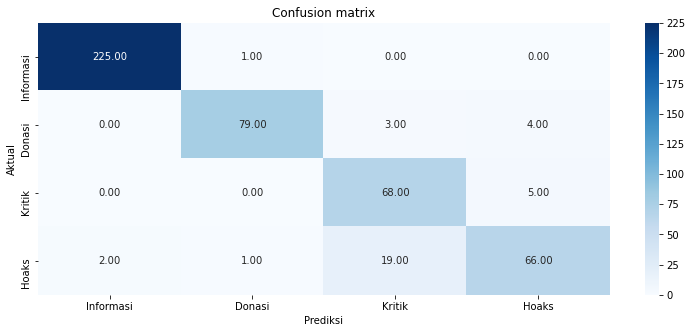

In [52]:
aux_df = df[['label', 'label_code']].drop_duplicates().sort_values('label_code')
conf_matrix = confusion_matrix(labels_test, svc_pred)
plt.figure(figsize=(12.8,5))
aux_df['label'].values[0]='Informasi'
aux_df['label'].values[1]='Donasi'
aux_df['label'].values[2]='Kritik'
aux_df['label'].values[3]='Hoaks'
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['label'].values, 
            yticklabels=aux_df['label'].values,
            cmap="Blues",fmt='.2f')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.title('Confusion matrix')
plt.show()

At this point, we could get the average time the model takes to get predictions. We want the algorithm to be fast since we are creating an app which will gather data from the internet and get the predicted categories. However, since the difference when predicting 10-20 observations will be very little, we won't take this into account.

However, the code below could do this task:

```python
features_time = features_train
elapsed_list = []
for i in range(0,10):
    
    start = time.time()
    predictions = best_lrc.predict(features_time)
    end = time.time()
    elapsed = end - start
    elapsed_list.append(elapsed)

mean_time_elapsed = np.mean(elapsed_list)
```

Let's see if the hyperparameter tuning process has returned a better model:

In [54]:
base_model = svm.SVC(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9386892177589852

In [55]:
best_svc.fit(features_train, labels_train)
accuracy_score(labels_test, best_svc.predict(features_test))

0.9260042283298098

We'll create a dataset with a model summary to compare models:

In [56]:
d = {
     'Model': 'SVM',
     'Training Set Accuracy': accuracy_score(labels_train, best_svc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, svc_pred)
}

df_models_svc = pd.DataFrame(d, index=[0])

In [57]:
df_models_svc

,Model,Training Set Accuracy,Test Set Accuracy
0,SVM,0.929746,0.926004


Let's save the model and this dataset:

In [53]:
with open('Models/best_svc.pickle', 'wb') as output:
    pickle.dump(best_svc, output)
    
with open('Models/df_models_svc.pickle', 'wb') as output:
    pickle.dump(df_models_svc, output)

dump(best_svc, 'Models/best_svc.joblib')

['Models/best_svc.joblib']

In [119]:
# Dataframe
path_df = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)
    
# X_train
path_X_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/X_train.pickle"
with open(path_X_train, 'rb') as data:
    X_train = pickle.load(data)

# X_test
path_X_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/X_test.pickle"
with open(path_X_test, 'rb') as data:
    X_test = pickle.load(data)

# y_train
path_y_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/y_train.pickle"
with open(path_y_train, 'rb') as data:
    y_train = pickle.load(data)

# y_test
path_y_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/y_test.pickle"
with open(path_y_test, 'rb') as data:
    y_test = pickle.load(data)

# features_train
path_features_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/03. Feature Engineering/Pickles_title/labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)
    
# SVM Model
path_model = "C:/Users/asus-pc/Documents/PBA/Tugas Akhir/04. Model Training/Models/best_svc.pickle"
with open(path_model, 'rb') as data:
    svc_model = pickle.load(data)
    
# Category mapping dictionary
category_codes = {
    'notification of information': 0,
    'donation': 1,
    'criticism': 2,
    'hoax': 3,
}

category_names = {
    0: 'notification of information',
    1: 'donation',
    2: 'criticism',
    3: 'hoax'
}

In [120]:
predictions = svc_model.predict(features_test)

In [121]:
# Indexes of the test set
index_X_test = X_test.index

# We get them from the original df
df_test = df.loc[index_X_test]

# Add the predictions
df_test['prediction'] = predictions

# Clean columns
df_test = df_test[['title', 'label', 'label_code', 'prediction']]

# Decode
df_test['label_predicted'] = df_test['prediction']
df_test = df_test.replace({'label_predicted':category_names})

# Clean columns again
df_test = df_test[['title', 'label', 'label_predicted']]

In [122]:
df_test.head()

,title,label,label_predicted
2182,Update Corona Indonesia 24 Oktober 2020 dan Se...,notification of information,notification of information
1279,Pertamina Diminta Lihat Fluktuasi Harga Minyak...,criticism,criticism
1729,UPDATE 17 Januari: Ada 145.482 Kasus Aktif Cov...,notification of information,notification of information
1477,"Sebaran 4.002 Kasus Positif Hari Ini, DKI-Jaba...",donation,donation
1964,UPDATE Corona 31 Maret di 32 Provinsi: Kasus B...,notification of information,notification of information


In [127]:
condition = (df_test['label'] != df_test['label_predicted'])

df_misclassified = df_test[condition]
df_misclassified.head(5)

,title,label,label_predicted
858,"Kasus Positif Corona Bertambah 1.014, Jawa Tim...",donation,notification of information
1531,Setelah Pulang dari Jakarta dan Berobat di Rum...,donation,criticism
1323,Polri Tak Akan Berikan Sanksi Hukum Ataupun De...,donation,criticism
945,Kominfo Catat Ada 2 Ribu Lebih Konten Hoax Ten...,hoax,criticism
1324,Polri Tidak Berikan Izin Keramaian Pelaksanaan...,donation,notification of information


In [128]:
len(df_misclassified)

39

In [135]:
def output_article(row_article):
    print('Actual Category: %s' %(row_article['label']))
    print('Predicted Category: %s' %(row_article['label_predicted']))
    print('-------------------------------------------')
    print('Text: ')
    print('%s' %(row_article['title']))

[1531, 1119, 1360]

In [157]:
output_article(df_misclassified.loc[list_samples[0]])

Actual Category: donation
Predicted Category: criticism
-------------------------------------------
Text: 
Setelah Pulang dari Jakarta dan Berobat di Rumah Sakit, Satu Keluarga di Bantul Terinfeksi Covid-19


In [158]:
output_article(df_misclassified.loc[list_samples[1]])

Actual Category: donation
Predicted Category: criticism
-------------------------------------------
Text: 
Narapidana Sumbangkan Hasil Karyanya untuk Penanganan Corona di Indonesia


In [159]:
output_article(df_misclassified.loc[list_samples[2]])

Actual Category: donation
Predicted Category: criticism
-------------------------------------------
Text: 
Presiden: Pandemi Berikan Pelajaran Pentingnya Berdikari
